# <center> 3$^{η}$ Εργασία: Βαθιά Μάθηση
| Ομάδα 13   |      AΜ      |  
|----------|:-------------:|
| Βεζάκης Ανδρέας  |  03117186 |
| Χατζηθεοδώρου Ιάσων |    03117089   |   
| Ζευγολατάκος Παναγιώτης  | 03117804 |    

In [1]:
FRACTION = 1
EPOCHS = 3

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import math
import sys
import warnings
from collections import Counter
from fractions import Fraction
from nltk.util import ngrams
import re
import gensim.downloader
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu,SmoothingFunction
from scipy.special import softmax
from math import log

## Read data Files and print them

Στο dataset που δημιουργήσαμε περιλαμβάνονται \<start> και \<end> σε αρχή και τέλος, επειδή στα αρχικά μοντέλα δεν χρησιμοποιούσαμε embeddings και ακολουθούσαμε τις οδηγίες του tutorial. Στο τελικό μοντέλο που περιλαμβάνει το Notebook χρησιμοποιούμε το μοντέλο InceptionResNetV2 καθώς και embeddings από το glove-wiki-gigaword-200 (δοκιμάσαμε και τις ύπολοιπες δυνατές τιμές, όπως 50,100, αλλά είχαμε παρόμοια αποτελέσματα) το οποίο επειδή δεν έχει εκπαιδευτεί με \<start> και \<end> θα χρειαστεί να τα αφαιρέσουμε πιο μετά. Υλοποιήσαμε την χρήση των embeddings με 2 τρόπους, στην αρχή δοκιμάσαμε να χρησιμοποιήσουμε το embedding layer που μας δίνεται από την tf.keras και να προσθέσουμε σε αυτό τα έτοιμα βάρη από το glove-wiki μοντέλο όπως παρουσιάζεται παρακάτω. <br> <center>self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=wembedding_dim,weights=[weights])</center>  <br>
Τα καλύτερα αποτελέσματα τα είχαμε στη συγκεκριμένη έκδοση, που περνάγαμε όλα τα captions από το w2v του έτοιμου μοντέλου. <br> 
Οι παράμετροι που επηρεάζουν περισσότερο το μοντέλο μας είναι το vocabulary_size, το μέγιστο μήκος των caption και το dropout. Με τιμές του ύψους 300.000, 20 και 0.4, 0.5 αντίστοιχα παρατηρήσαμε τα καλύτερα αποτελέσματα. Τέλος, κρατάμε μόνο τα captions που έχουν ελάχιστον μήκος 5 και μέγιστο 20. <br>
Όταν τρέξαμε τον ίδιο κώδικα αλλά με 512 μονάδες LSTM αντί για GRU (με τις 512 μονάδες είχαμε το πιο ικανοποιητικό αποτέλεσμα, αν και για όσες τιμές δοκιμάσαμε τα σκορ τους κυμαίνονταν γύρω από παρόμοια σκορ) είχαμε σχεδόν ίδια αποτελέσματα εκτός από όταν κάναμε greedy search που είχαμε 0.01 χειρότερη επίδοση. Το Beam Search θα είχε καλύτερη απόδοση από και τα δύο.

In [3]:
with open('../input/images-with-captions/df(1).npy', 'rb') as f:
    df_train = pd.DataFrame(np.load(f,allow_pickle=True), columns=['Caption', 'Image', 'Index'])
    df_test = pd.DataFrame(np.load(f,allow_pickle=True), columns=['Image'])

In [4]:
df_test.head()

,Image
0,_1000400860.jpg
1,_100046208.jpg
2,_1000933460.jpg
3,_1003969002.jpg
4,_10042424.jpg


In [5]:
df_train.head()

,Caption,Image,Index
0,<start> A little girl holds orange lilies whil...,_1000070808.jpg,0
1,<start> A little girl at a wedding holds a bou...,_1000070808.jpg,1
2,<start> Young girl in orange dress holding ora...,_1000070808.jpg,2
3,<start> a girl at a wedding holding some orang...,_1000070808.jpg,3
4,<start> A girl holds a bouquet of flowers <end>,_1000070808.jpg,4


In [6]:
# Download image files

image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',

                                      cache_subdir=os.path.abspath('.'),

                                      origin='https://www.dropbox.com/s/efqe8131slq1zah/flickr30k-images-ecemod.zip?dl=1',

                                      extract=True)

os.remove(image_zip)

4376395776/4376381805 [==============================] - 96s 0us/step


<start> A little girl holds orange lilies while others celebrate an occasion in a garden setting . <end>


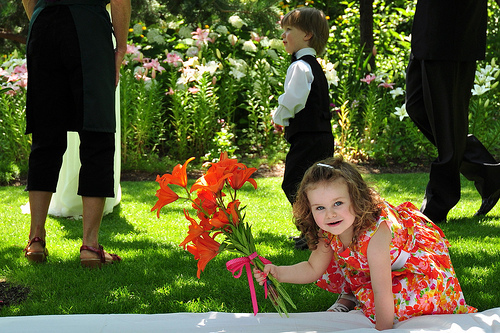

In [7]:
print(df_train['Caption'][0])
Image.open('./image_dir/' + df_train['Image'][0])

## Download glove-wiki embeddings

In [8]:
model_200 = gensim.downloader.load('glove-wiki-gigaword-200') #other size are 50,100,200,300
print(model_200.vectors.shape)
w2v = model_200

[=============================================-----] 90.1% 227.1/252.1MB downloaded
(400000, 200)


## Initialize InceptionV3 and load the pretained Imagenet weights

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


2022-03-09 12:35:12.006696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 12:35:12.104361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 12:35:12.105159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 12:35:12.107447: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


## Initialize InceptionResNetV2 and load the pretained Imagenet weights

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [11]:
image_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                                weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

219070464/219055592 [==============================] - 1s 0us/step


In [12]:
hidden_layer

<KerasTensor: shape=(None, None, None, 1536) dtype=float32 (created by layer 'conv_7b_ac')>

## Caching the features extracted from our CNN Keras Model:

#### Ο encoder μας, λαμβάνει είσοδο (299,299,3) και παράγει ένα vector με (8,8,1536)

In [13]:
# Get unique images
encode_train = sorted(set('./image_dir/'+df_train['Image']))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


  0%|          | 0/1862 [00:00<?, ?it/s]2022-03-09 12:35:23.896952: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-09 12:35:24.855905: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 1862/1862 [08:26<00:00,  3.67it/s]


## Preprocess captions

In [14]:
def standardize(inputs, emb = False):
    if emb:
        inputs = inputs.lower()
        inputs = re.sub(r"[<>!\"$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]", "", inputs)
        return ' '.join(inputs.split())
    else:
        # We will override the default standardization of TextVectorization to preserve
        # "<>" characters, so we preserve the tokens for the <start> and <end>.
        inputs = tf.strings.lower(inputs)
        return tf.strings.regex_replace(inputs,r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")
    

def preprocess_captions(min_len,max_len, emb = True):
    train_captions = []
    train_img_name_vector = []
    
#     caption = [standardize(cap, emb) for cap in df_train['Caption']] # Standardize captions
    
    if emb:
        for cap, img in zip(df_train['Caption'],df_train['Image']): 
            
            cap = cap.replace('<start>', "#") #Στο dataset που ειχαμε φτιαξει, υπήρχαν ήδη <start> και <end> στην αρχή και το τέλος αντίστοιχα
            cap = cap.replace('<end>', "") #Τα αφαιρούμε επειδή τα w2v μοντέλα δεν έχουν στην αρχή <start>
            cap_len = len(cap.split(" "))
            cap = standardize(cap, emb)
            if cap_len < min_len or cap_len > max_len:
                continue
            else:
                padding = max_len - cap_len  #Προσθέτουμε padding για να έχουν όλα τα captions το ίδιο μήκος. Επιλέξαμε τυχαία το '*',
                                                 # καθώς μπορούμε να το αγνοήσουμε στο loss function.
                if str(cap).split(" ")[-2] != ".":
                    cap = str(cap)+ " ."
                    
                padding = max_len - len(cap.split(" "))
                train_captions.append(str(cap) + ' *' * padding)
                    
                train_img_name_vector.append('./image_dir/'+str(img))

        return train_captions,train_img_name_vector
    else: 
        for cap, img in zip(df_train['Caption'],df_train['Image']): 
            cap = standardize(cap, emb)
            # Αν δεν χρησιμοποιούμε embedding τότε θέλουμε να κρατήσουμε τα <start>, <end>
            cap_len = len(cap.split(" "))
            if cap_len < min_len or cap_len > max_len:
                continue
            else:
                train_captions.append(str(cap))
                train_img_name_vector.append('./image_dir/'+str(img))
        
        return train_captions,train_img_name_vector
        
min_len = 6
max_len = 20

train_captions,train_img_name_vector = preprocess_captions(min_len,max_len)
print(len(train_captions),len(train_img_name_vector))

133365 133365


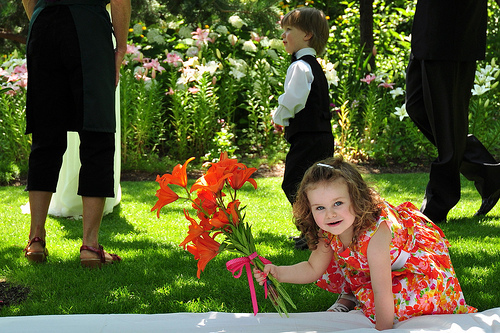

In [15]:
Image.open(train_img_name_vector[0])

In [16]:
embddings = True
# Max word count for a caption.
max_length = 20

# Use the top 300.000 words for a vocabulary. #tutorial has vocab_size = 50.000
vocabulary_size = 300000


cap_vector = tf.data.Dataset.from_tensor_slices(train_captions)

In [17]:
if not embddings:
    caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)
    tokenizer = tf.keras.layers.TextVectorization(
        max_tokens=vocabulary_size,
        standardize=standardize,
        output_sequence_length=max_length)
        # Learn the vocabulary from the caption data.
    tokenizer.adapt(caption_dataset)

    # Create the tokenized vectors
    cap_vector = caption_dataset.map(lambda x: tokenizer(x))
    # Create mappings for words to indices and indicies to words.
    word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

## Split the data into training and testing

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip( train_img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

# Select some of the images
img_keys = img_keys[:len(img_keys) // FRACTION]
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(106705, 106705, 26660, 26660)

## Create a tf.data dataset for training

In [20]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = w2v.vectors.shape[1] # Το μήκος του embedding που χρησιμοποιούμε (σε αυτή τη περίπτωση = 200)
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048), from InceptionResNetV2 is (64, 1536)
# These two variables represent that vector shape
features_shape = 1536
attention_features_shape = 64

# Load the numpy files
def map_func(img_name, cap):
    caption = []
    index = []
    for w in str(cap).split(" "):
        # Get the embeddings and indexes
        try:
            caption.append(w2v.get_vector(w))
            index.append(w2v.key_to_index[w])
            if index[-1] >= vocabulary_size:
                index[-1] = w2v.key_to_index["*"]
        except KeyError: # KeyErrors were appearing, so had to do try, except. "*" will be ignored in loss function
            caption.append(w2v.get_vector("*"))
            index.append(w2v.key_to_index["*"])
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, tf.convert_to_tensor(caption, dtype=tf.float32), tf.convert_to_tensor(index, dtype=tf.int32)

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [21]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, weights):
    
    super(RNN_Decoder, self).__init__()
    self.units = units
    


    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.dropout = tf.keras.layers.Dropout(0.4)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
#     x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
   # passing the concatenated vector to the LSTM
#     output, state, final_carry_state = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    x = self.dropout(x)
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [22]:
vocabulary_size = 300000
embedding_dim = 200
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocabulary_size, w2v.vectors)

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, w2v.key_to_index["*"]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Training

In [24]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


In [25]:
@tf.function
def train_step(img_tensor, target, target_indexes):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tf.convert_to_tensor(w2v.get_vector("#"))] * target.shape[0],1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
     
        for i in range(1, target.shape[1]):

            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target_indexes[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [26]:
start_epoch = 0

for epoch in tqdm_notebook(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target, target_indexes)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, target_indexes)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
 

  0%|          | 0/3 [00:00<?, ?it/s]

2022-03-09 12:44:06.500651: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
2022-03-09 12:44:07.198661: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.


Epoch 1 Batch 0 Loss 7.1931


2022-03-09 12:44:29.828568: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
2022-03-09 12:44:30.462635: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
2022-03-09 12:44:31.100265: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.


Epoch 1 Batch 100 Loss 3.2118
Epoch 1 Batch 200 Loss 2.7234
Epoch 1 Batch 300 Loss 2.6033
Epoch 1 Batch 400 Loss 2.2931
Epoch 1 Batch 500 Loss 2.4484
Epoch 1 Batch 600 Loss 2.1806
Epoch 1 Batch 700 Loss 2.3614
Epoch 1 Batch 800 Loss 2.1356
Epoch 1 Batch 900 Loss 2.1548
Epoch 1 Batch 1000 Loss 1.9640
Epoch 1 Batch 1100 Loss 2.0769
Epoch 1 Batch 1200 Loss 1.9825
Epoch 1 Batch 1300 Loss 2.1181
Epoch 1 Batch 1400 Loss 2.0970
Epoch 1 Batch 1500 Loss 2.1818
Epoch 1 Batch 1600 Loss 2.0301
Epoch 1 Loss 2.297558
Time taken for 1 epoch 1085.88 sec

Epoch 2 Batch 0 Loss 1.8577
Epoch 2 Batch 100 Loss 1.9530
Epoch 2 Batch 200 Loss 1.9013
Epoch 2 Batch 300 Loss 2.0607
Epoch 2 Batch 400 Loss 1.8697
Epoch 2 Batch 500 Loss 1.7314
Epoch 2 Batch 600 Loss 1.9047
Epoch 2 Batch 700 Loss 1.9469
Epoch 2 Batch 800 Loss 1.8112
Epoch 2 Batch 900 Loss 1.8811
Epoch 2 Batch 1000 Loss 1.7376
Epoch 2 Batch 1100 Loss 1.9039
Epoch 2 Batch 1200 Loss 1.5717
Epoch 2 Batch 1300 Loss 1.7168
Epoch 2 Batch 1400 Loss 1.7861
Ep

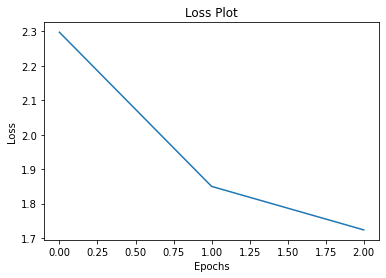

In [27]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


## Generate and Evaluate Caption


In [28]:
def evaluate(image, categorical = True):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tf.convert_to_tensor(w2v.get_vector("#"))],0)
    result = []
    indices = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        if categorical:
            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        else:
            predicted_id = tf.math.argmax(predictions, axis=1)[0].numpy()
        
        indices.append(predicted_id)
        predicted_word = tf.compat.as_text(w2v.index_to_key[predicted_id])
        result.append(predicted_word)
        
        if predicted_word == '.':
            #print(f'Best indices: {indices}')
            return result, attention_plot

        dec_input = tf.expand_dims([w2v.get_vector(predicted_word)], 0)
    
    attention_plot = attention_plot[:len(result), :]
    
    if result[-1] != '.':
        result.append('.')
    
    return result, attention_plot

In [29]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: four employees trying to take a cafe .


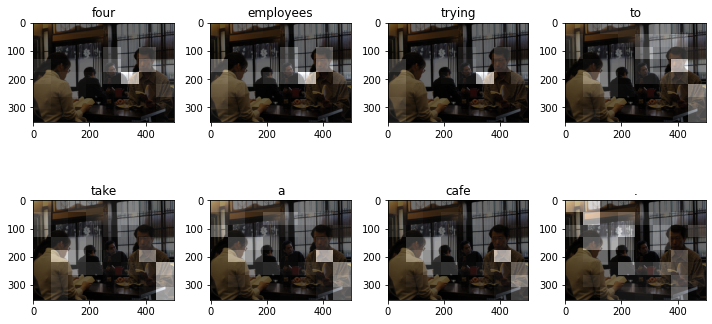

In [30]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
result, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Παρακάτω φαίνεται η υλοποίησή μας για το Beam Search. Για κάθε μία από τις $b$ προτάσεις εξερευνούσαμε όλες τις πιθανές προτάσεις που θα μπορούσαν να παραχθούν με προσθήκη μιας λέξης και κρατούσαμε τις $b$ πιθανότερες για επιτάχυνση. Έπειτα, κρατούσαμε από αυτές τις $b^2$ τις $b$ πιθανότερες. Για τον υπολογισμό των πιθανοτήτων αποθηκεύαμε για κάθε πρόταση την log-πιθανότητά της μέχρι εκείνο το σημείο και προσθέταμε σε αυτήν την πιθανότητα που έβγαζε ως έξοδο το decoder. Επίσης, για κάθε πρόταση αποθηκεύαμε και το hidden state ώστε να συνεχίσει σωστά με τον υπολογισμό το decoder.

In [31]:
def evaluate_BeamSearch(image, max_length=20, b=10):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    #dec_input = tf.expand_dims([tf.convert_to_tensor(w2v.get_vector("#"))],0)
    result = []
    
    # All words
    all_words = [tf.compat.as_text(w2v.index_to_key[word_id]) for word_id in range(vocabulary_size)]
    
    # List of lists [sentence, log-probability, hidden]
    b_selected = [[["#"], 0, hidden]]
    
    # Finished sentences
    finished = []
    
    for i in range(max_length):
        #print(f'Starting iteration {i}:')
        temp_results = []
        temp_probs = []
        temp = []
        for x in b_selected:
            # Get the sentence, its probability and the hidden state
            selected, prob, hidden = x[0], x[1], x[2]
            
            # If this sentence is finished then save it and continue to the next one
            if selected[-1] == '.':
                finished.append([selected, prob])
                continue
                        
            # Maybe hidden must be saved for each prediction
            predictions, new_hidden, attention_weights = decoder(tf.expand_dims([tf.convert_to_tensor(w2v.get_vector(selected[-1]))],0), 
                                                             features, 
                                                             hidden)
        
            # No reason to keep more than the b highest
            highest = tf.math.top_k(predictions[0], k=b)
            indices = highest.indices.numpy().tolist()
            
            # Add the previous probabilities to predictions to get the total probability
            #print(f'Probability of {selected} is {prob}')
            total_predictions = [predictions[0][idx] + prob for idx in indices]
            
            # Create all possible new words with their probabilities
            temp_results = [selected + [all_words[idx]] for idx in indices]   
            temp_probs = total_predictions
            # Turn logits to log probabilities (might be unnecessary)
            #temp_probs = np.log(softmax(total_predictions)) 
            
            # Create the list of new options
            temp += [[res, prob, new_hidden] for res, prob in zip(temp_results, temp_probs)]
            
            #print(f'Tried to expand {selected} and the best choices were {[all_words[idx] for idx in indices]} with probabilities: {total_predictions}')
            
        # Sort all possible sentences 
        temp = sorted(temp, key=lambda x: x[1], reverse=True)
        
        # Select b highest probabilities if they exist
        end = min(b+1, len(temp))
        b_selected = temp[:end]
        #print([x[0] for x in b_selected])

    for x in b_selected:
        selected, prob = x[0], x[1]
        if selected[-1] != '.':
            selected.append('.')
            finished.append([selected, prob])
    
    result = sorted(finished, key=lambda x: x[1], reverse=True)[0][0]
    return result 

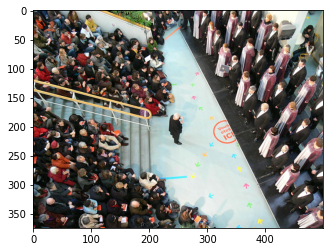

Beam Search Caption: # a group of people are standing in front of a crowd of people are taking pictures in front of a .
Normal Caption: several people are lying on his red wall .


In [32]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
temp_image = Image.open(image)
plt.imshow(temp_image)
plt.show()

result_BeamSearch = evaluate_BeamSearch(image)
print('Beam Search Caption:', ' '.join(result_BeamSearch))

result, attention_plot = evaluate(image, categorical=True)
print('Normal Caption:', ' '.join(result))

## Evaluate Caption

In [33]:
def evaluate_captions(categorical=True, beam_search=False):
    img_2_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_val, cap_val):
        img_2_cap_vector[img].append(cap)

    total_refs = []
    total_hyps = []

    for img in tqdm(list(img_2_cap_vector.items())[:1000]):

        refl = []
        for ref in img[1]:
            ref = tf.compat.as_text(ref.numpy())
            ref = ref.split(".")[0]
            ref = ref.split(" ")[1:-1]
            refl.append(ref)        

        
        if beam_search:
            hyp = evaluate_BeamSearch(img[0])
        else:
            hyp, _ = evaluate(img[0], categorical)
        hyp = hyp[:-1]
        total_refs.append(refl)
        total_hyps.append(hyp)
        
    return total_refs,total_hyps

In [34]:
weights = (0.4, 0.3, 0.2, 0.1) 
chencherry = SmoothingFunction()

In [35]:
refs,total_hyp = evaluate_captions(True)
corpus_bleu(refs, total_hyp, weights = weights, smoothing_function=chencherry.method1)

100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


0.08472368018272604

In [36]:
refs,total_hyp = evaluate_captions(False)
corpus_bleu(refs, total_hyp, weights = weights, smoothing_function=chencherry.method1)

100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


0.17584125123526329

In [37]:
refs,total_hyp = evaluate_captions(beam_search=True)
corpus_bleu(refs, total_hyp, weights = weights, smoothing_function=chencherry.method1)

100%|██████████| 1000/1000 [1:00:39<00:00,  3.64s/it]


0.12599268064033642

Για τον ίδιο αριθμό εποχών: <br>
Με Gru: categorical 0.08, greedy: 0.18 <br>
Με lstm: categorical 0.08, greedy: 0.177

* Επιτυχημένα caption

Prediction Caption: five man and a small boy .


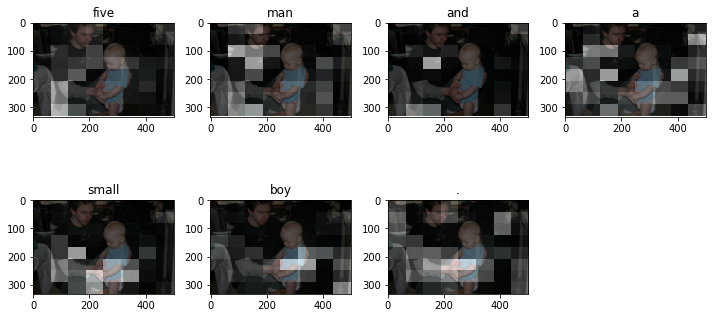

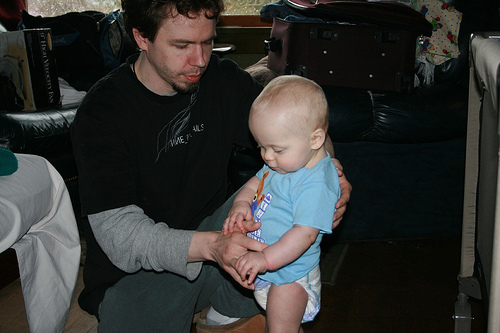

In [38]:
image = img_name_val[40]
result, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

Prediction Caption: a dog standing by side .


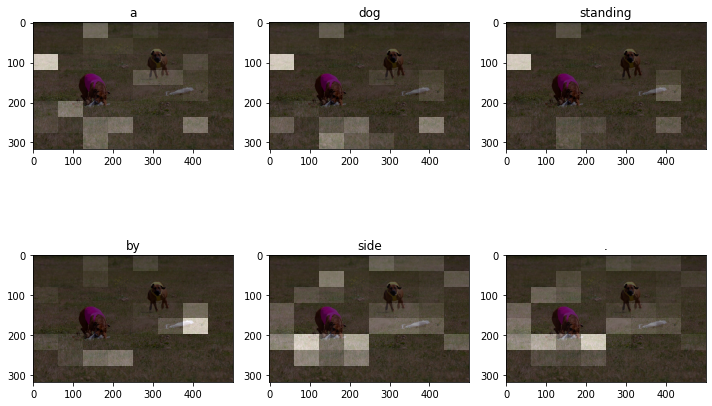

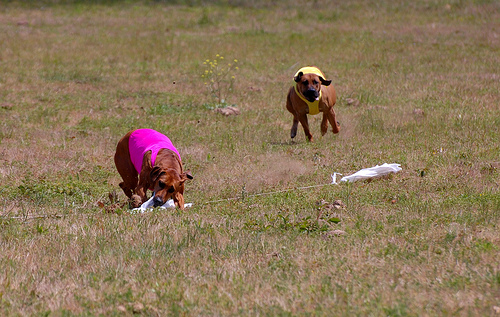

In [39]:
image = img_name_val[10]
result, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

* Αποτυχημένα Caption

Prediction Caption: his dogs .


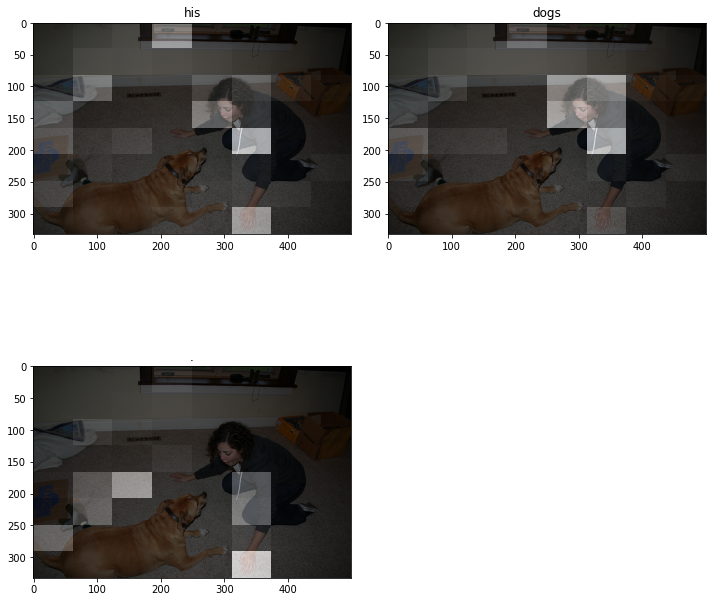

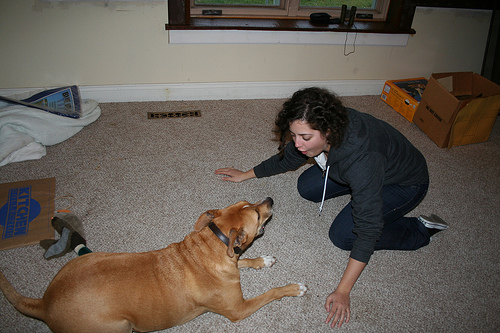

In [40]:
image = img_name_val[20]
result, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

Prediction Caption: him while sitting in the air .


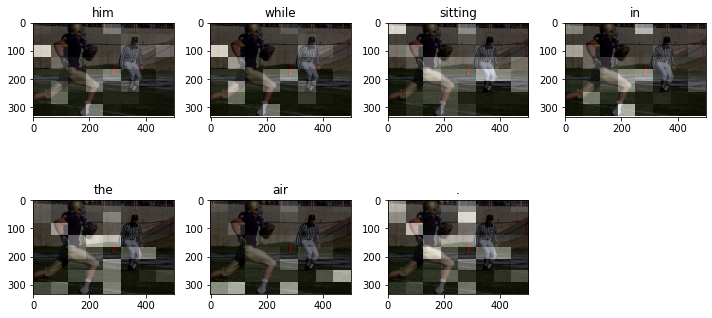

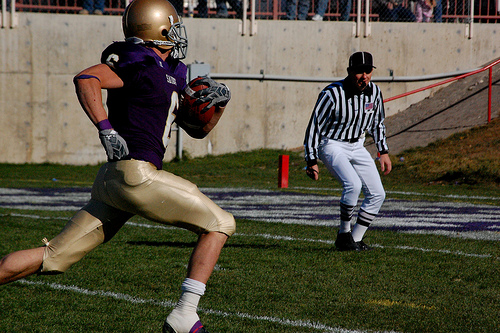

In [41]:
image = img_name_val[100]
result, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)